In [91]:
import os
import numpy as np
import mne

from repo import SubjectData

In [92]:
os.environ["TASK"] = 'baseline'
os.environ["MAT"] = 's01'

In [93]:
import logging
logging.basicConfig(filename=f'logs/{os.environ["TASK"]}.log', level=logging.DEBUG)

In [94]:
sd = SubjectData(f'data/{os.environ["MAT"]}')
logging.info(f'File: {os.environ["MAT"]}')

Creating RawArray with float64 data, n_channels=69, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Creating RawArray with float64 data, n_channels=69, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Creating RawArray with float64 data, n_channels=69, n_times=71680
    Range : 0 ... 71679 =      0.000 ...   139.998 secs
Ready.
Creating RawArray with float64 data, n_channels=69, n_times=71680
    Range : 0 ... 71679 =      0.000 ...   139.998 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=34048
    Range : 0 ... 34047 =      0.000 ...    66.498 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=5120
    Range : 0 ... 5119 =      0.000 ...     9.998 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=5120
    Range : 0 ... 5119 =      0.000 ...     9.998 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=5120
    Range : 0 ... 5119 =      0.

In [117]:
mat_all = np.hstack(
#     list(sd.mat_noise) + 
    [
#         sd.mat_rest, 
#         sd.mat_movement_left, 
#         sd.mat_movement_right, 
        sd.mat_imagery_left, 
#         sd.mat_imagery_right
    ])
raw_all = mne.io.RawArray(mat_all, sd.raw_rest.info)
raw_all.set_montage(sd.raw_rest.get_montage())

Creating RawArray with float64 data, n_channels=68, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.


<RawArray | 68 x 358400 (700.0 s), ~186.1 MB, data loaded>

In [118]:
ica = mne.preprocessing.ICA(n_components=64, random_state=97, max_iter=1000)
ica.fit(raw_all)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 64 components
Fitting ICA took 42.7s.


<ICA | raw data decomposition, fit (fastica): 358400 samples, 64 components, channels used: "eeg">

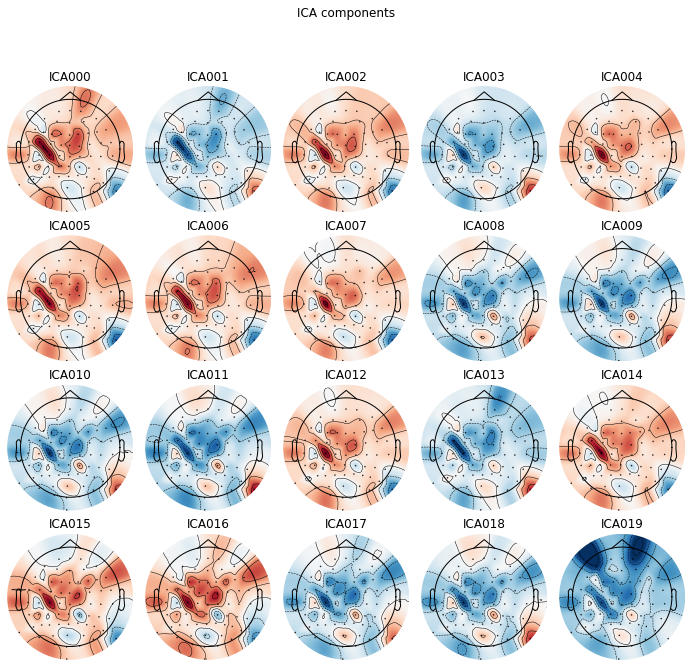

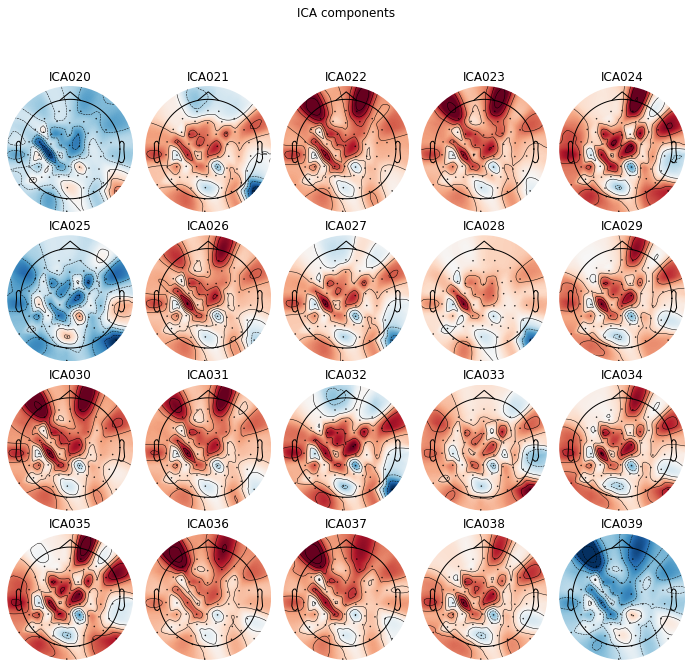

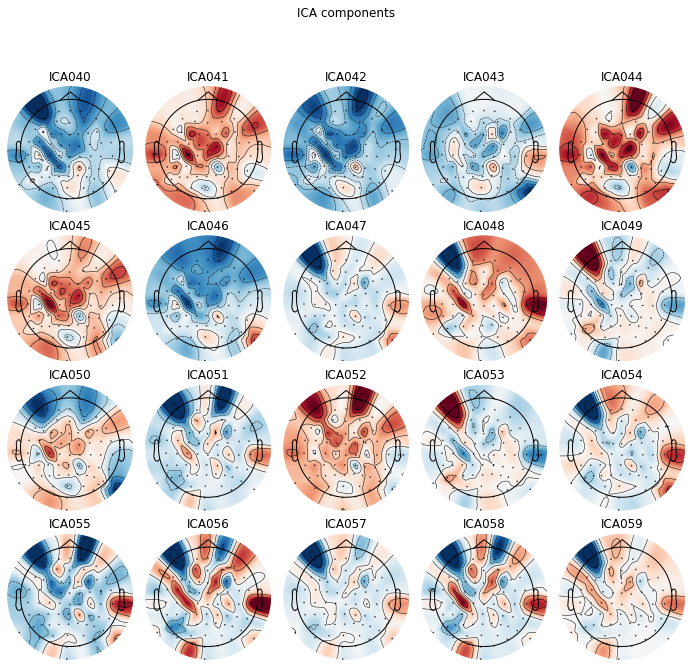

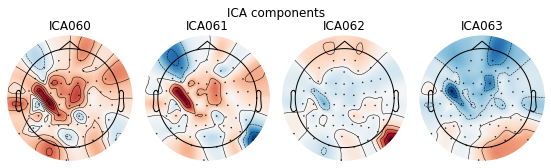

[<Figure size 702x678.24 with 20 Axes>,
 <Figure size 702x678.24 with 20 Axes>,
 <Figure size 702x678.24 with 20 Axes>,
 <Figure size 561.6x169.56 with 4 Axes>]

In [119]:
ica.plot_components()

In [122]:
ica.excludes = [0, 24, 25]

In [123]:
tmin = -1
tmax = 4
reject_criteria = {'eeg': 350e-6}       # 150 µV The default from the overview tutorial
filter_freqs = (7, 30)
filter_props = dict(picks=['eeg'], fir_design='firwin', skip_by_annotation='edge')

In [124]:
imagery_events = mne.find_events(sd.raw_imagery_left, stim_channel=sd.stim_channel)
im_left_epochs = mne.Epochs(
    sd.raw_imagery_left, imagery_events, tmin=tmin, tmax=tmax, preload=True
).filter(*filter_freqs, **filter_props).drop_bad(reject_criteria)
imagery_events = mne.find_events(sd.raw_imagery_right, stim_channel=sd.stim_channel)
im_right_epochs = mne.Epochs(
    sd.raw_imagery_right, imagery_events, tmin=tmin, tmax=tmax,preload=True
).filter(*filter_freqs, **filter_props).drop_bad(reject_criteria)

100 events found
Event IDs: [1]
Not setting metadata
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 100 events and 2561 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (1.650 sec)

0 bad epochs dropped
100 events found
Event IDs: [1]
Not setting metadata
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 100 events and 256

In [125]:
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from mne.decoding import CSP, UnsupervisedSpatialFilter

In [126]:
#im_left_epochs = im_left_epochs#.copy().crop(tmin=1., tmax=2.)   # Not sure why the guy cropped this
# im_left_data = im_left_epochs.copy().pick_types(eeg=True)
# im_right_data = im_right_epochs.copy().pick_types(eeg=True)
im_left_data = ica.get_sources(im_left_epochs)
im_right_data = ica.get_sources(im_right_epochs)
im_left_labels = im_left_epochs.events[:, -1] - 1   # Label: 0
im_right_labels = im_right_epochs.events[:, -1]     # Label: 1

im_data = np.vstack((im_left_data.get_data(), im_right_data.get_data()))
im_labels = np.hstack((im_left_labels, im_right_labels))

print('Left Imagery Data Shape:', im_left_data.get_data().shape)
print('Right Imagery Data Shape:', im_right_data.get_data().shape)
logging.info(f'Left Imagery Data Shape: {im_left_data.get_data().shape}')
logging.info(f'Right Imagery Data Shape: {im_right_data.get_data().shape}')

Left Imagery Data Shape: (100, 64, 2561)
Right Imagery Data Shape: (100, 64, 2561)


In [127]:
im_data = UnsupervisedSpatialFilter(PCA()).fit_transform(im_data)

In [128]:
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, im_data, im_labels, cv=cv, n_jobs=8)

class_balance = np.mean(im_labels == im_labels[0])
class_balance = max(class_balance, 1. - class_balance)

In [129]:
print("Classification accuracy:", np.mean(scores))
print("Class balance:", class_balance)
logging.info(f"Classification scores: {list(scores)}")
logging.info(f"Classification accuracy: {np.mean(scores)}")
logging.info(f"Class balance: {class_balance}")

Classification accuracy: 0.7675
Class balance: 0.5
